In [1]:
import pandas as pd
from igraph import Graph, plot, RainbowPalette
import matplotlib.pyplot as plt

In [2]:
# load data
city_name = 'Dublin'
nodes_edges_name = 'friends'

nodes = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city_name}_{nodes_edges_name}_edges.csv')

In [3]:
# create graph
net = Graph.DataFrame(edges, directed=True, use_vids=False, vertices=nodes)

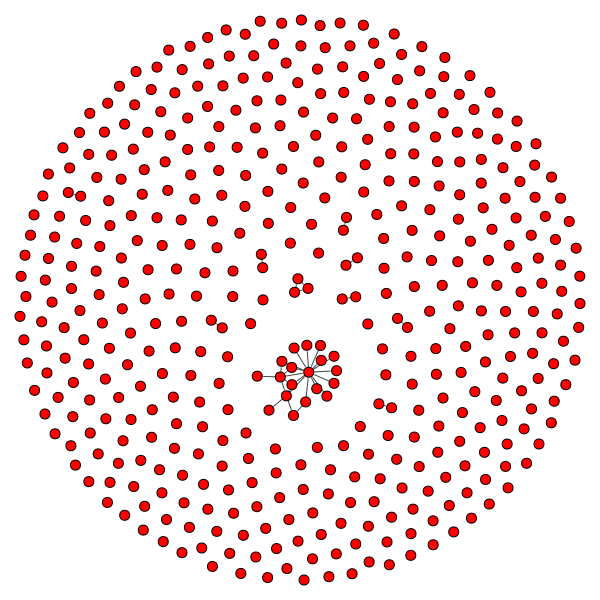

In [4]:
plot(net, edge_arrow_size=0.1, vertex_size=10)